In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PowerTransformer

In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "water_potability.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "adityakadiwal/water-potability",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

df.head()

/tmp/ipython-input-5-3208697581.py:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0

In [ ]:
display(df.describe().T)
display(df.isna().sum())


# In Potability 0 = safe and 1 = not safe

count          mean          std         min           25%  \
ph               2785.0      7.080795     1.594320    0.000000      6.093092   
Hardness         3276.0    196.369496    32.879761   47.432000    176.850538   
Solids           3276.0  22014.092526  8768.570828  320.942611  15666.690297   
Chloramines      3276.0      7.122277     1.583085    0.352000      6.127421   
Sulfate          2495.0    333.775777    41.416840  129.000000    307.699498   
Conductivity     3276.0    426.205111    80.824064  181.483754    365.734414   
Organic_carbon   3276.0     14.284970     3.308162    2.200000     12.065801   
Trihalomethanes  3114.0     66.396293    16.175008    0.738000     55.844536   
Turbidity        3276.0      3.966786     0.780382    1.450000      3.439711   
Potability       3276.0      0.390110     0.487849    0.000000      0.000000   

                          50%           75%           max  
ph                   7.036752      8.062066     14.000000  
Hardness           196.967627    216.667456    323.124000  
Solids           20927.833607  27332.762127  61227.196008  
Chloramines          7.130299      8.114887     13.127000  
Sulfate            333.073546    359.950170    481.030642  
Conductivity       421.884968    481.792304    753.342620  
Organic_carbon      14.218338     16.557652     28.300000  
Trihalomethanes     66.622485     77.337473    124.000000  
Turbidity            3.955028      4.500320      6.739000  
Potability           0.000000      1.000000      1.000000

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)
display(df_imputed.isna().sum())

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

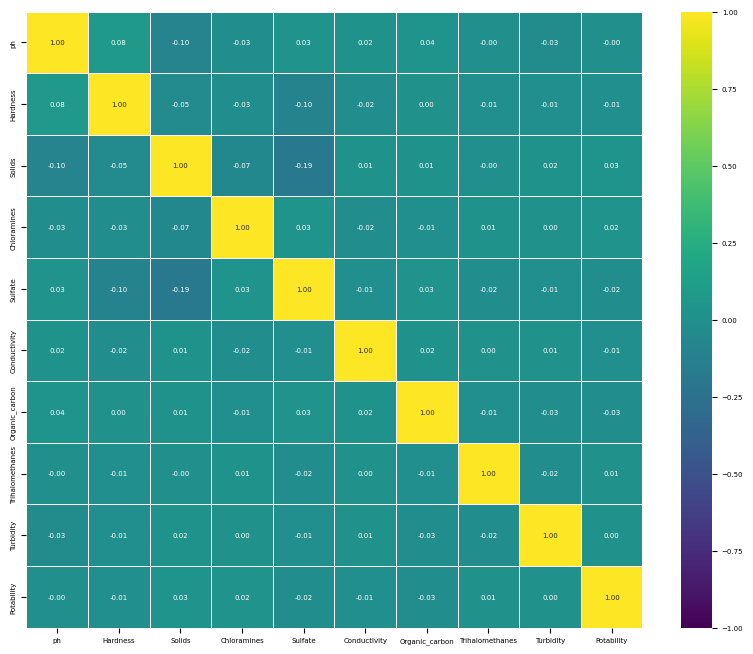

In [ ]:

# Calculate the correlation matrix
correlation_matrix = df_imputed.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize = (10,8))
plt.rcParams.update({'font.size': 5})
sns.heatmap(correlation_matrix, cmap = 'viridis', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5)
plt.show()

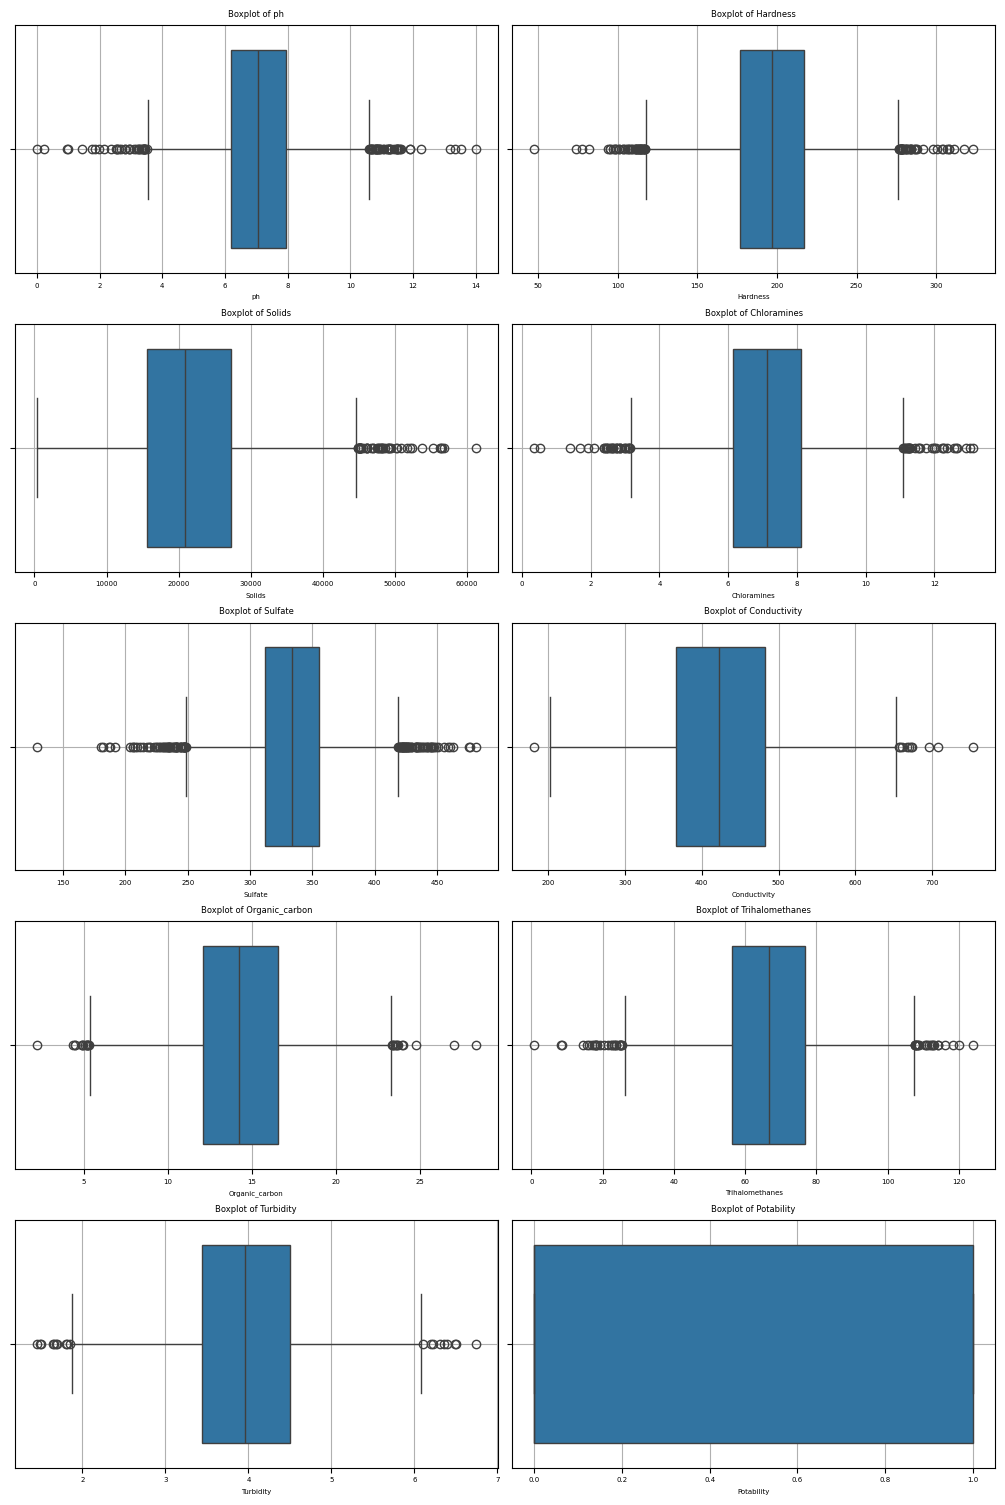

In [ ]:
fig, ax = plt.subplots(5,2 , figsize=(10, 15))
ax = ax.flatten()
for i, column in enumerate(df_imputed.columns):
    sns.boxplot(x=df_imputed[column], ax=ax[i])
    ax[i].set_title(f'Boxplot of {column}')
    ax[i].grid(True)

plt.tight_layout()
plt.show()

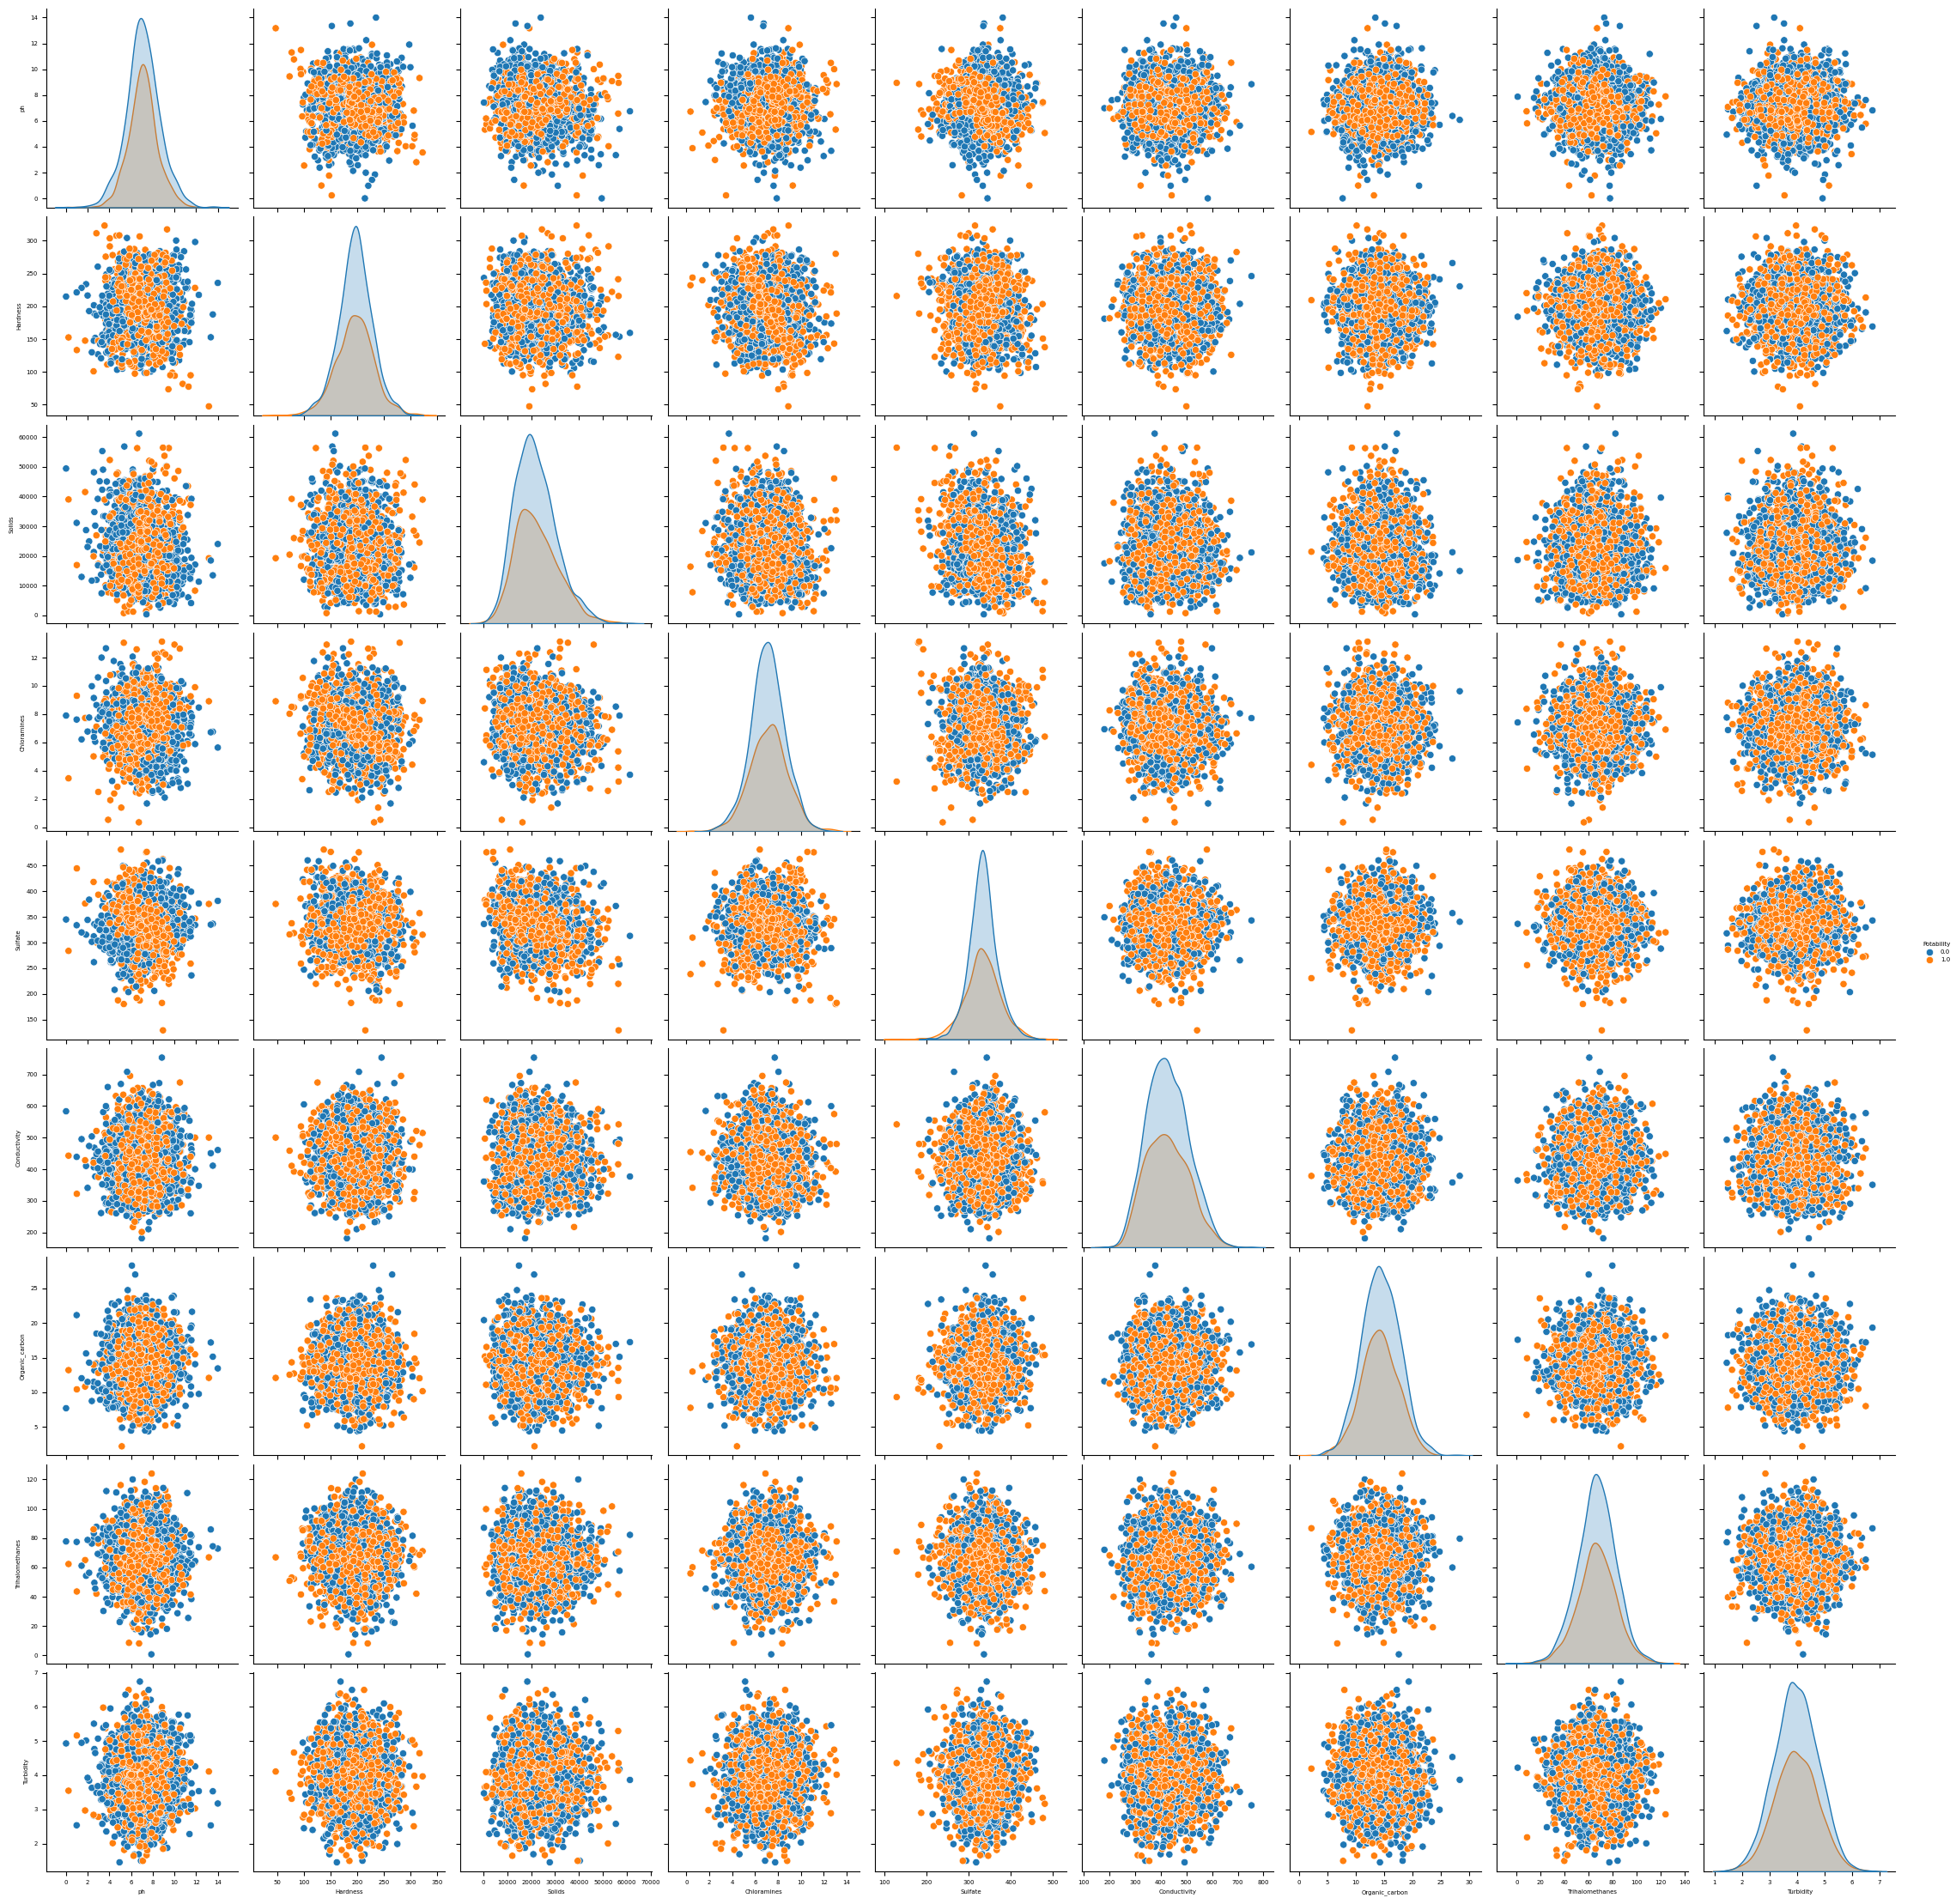

In [ ]:
sns.pairplot(df_imputed , hue='Potability')

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier

In [ ]:
X = df_imputed[df_imputed.columns[:-1]]
y = df_imputed['Potability']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


models_and_params = {
    'LogisticRegression': {
        'model': LogisticRegression(solver='liblinear', random_state=42),
        'params': {
            'classifier__C': [0.01, 0.1, 1, 10, 100],
            'classifier__penalty': ['l1', 'l2']
        }
    },
    'SVC': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__gamma': [1, 0.1, 0.01],
            'classifier__kernel': ['rbf', 'linear', 'poly']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'classifier__n_estimators': [100, 200, 500],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.05, 0.1],
            'classifier__subsample': [0.7, 0.8, 1.0],
            'classifier__colsample_bytree': [0.7, 0.8, 1.0]
        }
    }
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}


for name, config in models_and_params.items():
    print(f"===== Training {name} with SMOTE Resampling =====")

    pipeline = Pipeline([
        ('resampler', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('classifier', config['model'])
    ])

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=config['params'],
        n_iter=5,
        cv=cv_strategy,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    random_search.fit(X_train, y_train)

    results[name] = {
        'best_estimator': random_search.best_estimator_,
        'best_params': random_search.best_params_,
        'best_score': random_search.best_score_
    }
    print(f"Best Score (ROC AUC) on CV: {random_search.best_score_:.4f}")
    print(f"Best Parameters: {random_search.best_params_}\n")


best_model_name = max(results, key=lambda name: results[name]['best_score'])
best_model = results[best_model_name]['best_estimator']

print(f"===== Best Model Found: {best_model_name} (CV ROC AUC Score: {results[best_model_name]['best_score']:.4f}) =====\n")

print(f"===== Final Evaluation of {best_model_name} on Test Set =====")
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Potable', 'Potable']))



===== Training LogisticRegression with SMOTE Resampling =====
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score (ROC AUC) on CV: 0.5000
Best Parameters: {'classifier__penalty': 'l1', 'classifier__C': 0.01}

===== Training SVC with SMOTE Resampling =====
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score (ROC AUC) on CV: 0.6822
Best Parameters: {'classifier__kernel': 'rbf', 'classifier__gamma': 0.1, 'classifier__C': 10}

===== Training RandomForest with SMOTE Resampling =====
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score (ROC AUC) on CV: 0.6884
Best Parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 20}

===== Training XGBoost with SMOTE Resampling =====
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:18:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Score (ROC AUC) on CV: 0.6754
Best Parameters: {'classifier__subsample': 0.7, 'classifier__n_estimators': 500, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.01, 'classifier__colsample_bytree': 0.7}

===== Best Model Found: RandomForest (CV ROC AUC Score: 0.6884) =====

===== Final Evaluation of RandomForest on Test Set =====
Classification Report:
              precision    recall  f1-score   support

 Not Potable       0.69      0.69      0.69       600
     Potable       0.51      0.50      0.51       383

    accuracy                           0.62       983
   macro avg       0.60      0.60      0.60       983
weighted avg       0.62      0.62      0.62       983




Generating Feature Importance plot for RandomForest...

Pipeline execution complete. All plots have been saved.


/tmp/ipython-input-18-3774352745.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


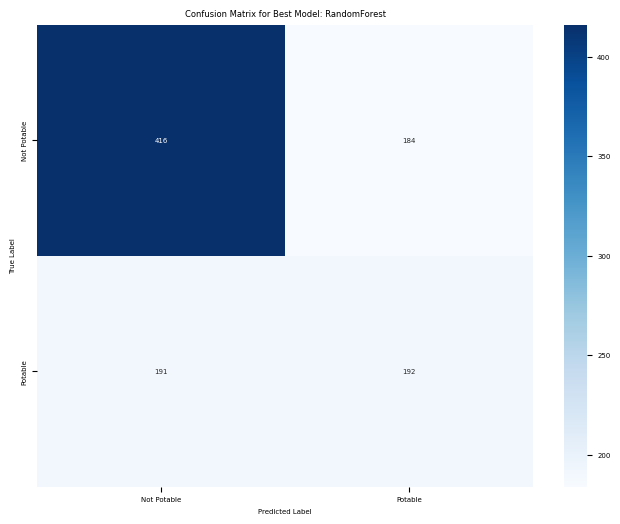

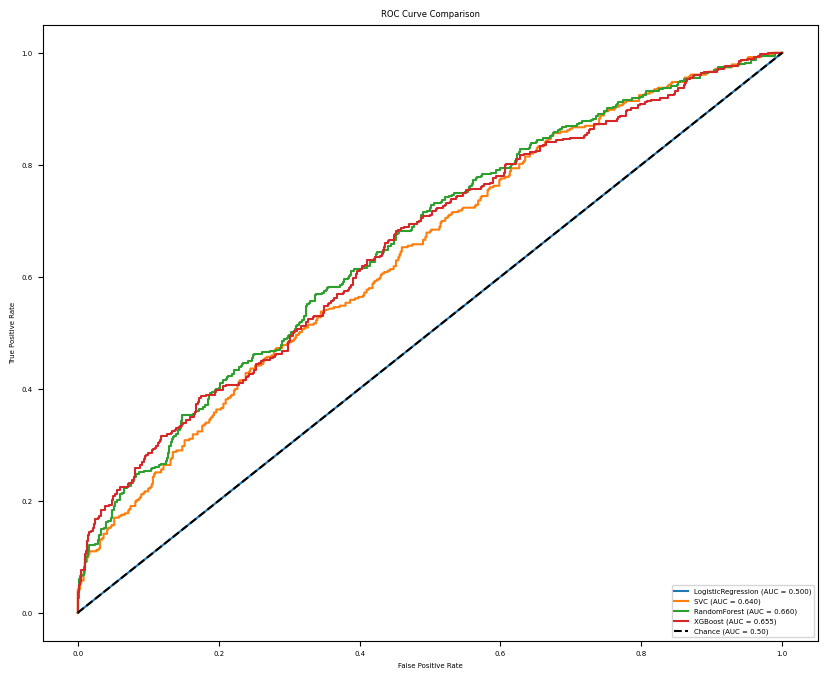

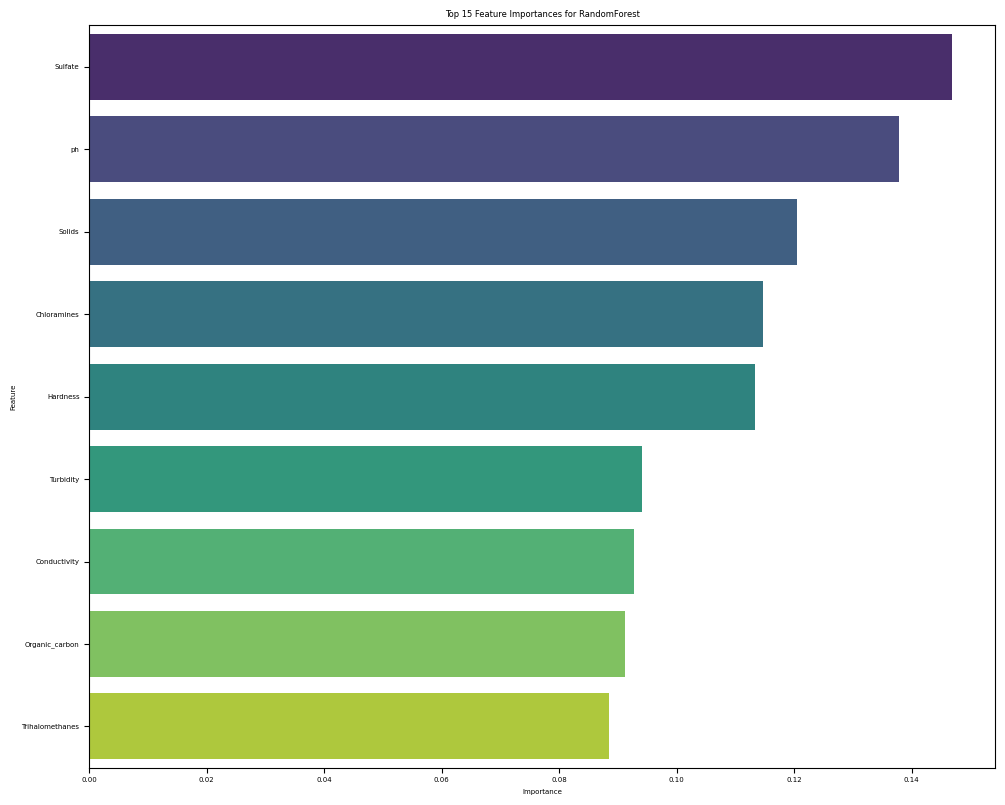

In [ ]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Potable', 'Potable'], yticklabels=['Not Potable', 'Potable'])
plt.title(f'Confusion Matrix for Best Model: {best_model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


# ROC Curve comparison for all models
plt.figure(figsize=(10, 8))
for name, result in results.items():
    model = result['best_estimator']
    y_pred_proba_model = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba_model)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')


# Feature Importance if the best model supports it
best_classifier = best_model.named_steps['classifier']
if hasattr(best_classifier, 'feature_importances_'):
    print(f"\nGenerating Feature Importance plot for {best_model_name}...")
    importances = best_classifier.feature_importances_
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).head(15)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
    plt.title(f'Top 15 Feature Importances for {best_model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()


print("\nPipeline execution complete. All plots have been saved.")